# Object Detection Demo

This example shows the usage of Mask R-CNN with MobileViT as an image encoder. The model is pre-trained on the COCO dataset for the task of object detection. 

Typical process for object detection involves:

1. ***Choose a Pre-trained Model:*** Select a pre-trained detection model. In this example, it is Mask R-CNN with MobileViT.
2. ***Preprocess Input Image:*** Preprocess the input image to match the requirements of the pre-trained model. This typically involves resizing, normalization, and any other preprocessing steps required by the specific model.
3. ***Generate detection output:*** Perform a forward pass of the input image through the pre-trained model to obtain the detection output. The model will output a detection results for each object present in the input image.

## STEP 1: Pre-trained model
Creating a model is simple. You need a configuration file and the path to the pre-trained weights. Below is an example code snippet

In [1]:
from corenet.options.opts import get_training_arguments
from corenet.modeling import get_model
from PIL import Image
import torch
from torchvision.transforms import Compose, Resize, PILToTensor
from torchvision.transforms import ToPILImage
import os
from corenet.modeling.models.detection import DetectionPredTuple
from torch.nn import functional as F
import numpy as np
from corenet.utils.visualization_utils import draw_bounding_boxes
import sys


# configuration file path
config_file = os.path.join(
    os.getcwd(),
    "..",
    "projects/range_augment/detection/maskrcnn_mobilevit.yaml",
)
# pre-trained weights
pretrained_weights = "https://docs-assets.developer.apple.com/ml-research/models/cvnets-v2/examples/range_augment/detection/maskrcnn_mobilevit.pt"

opts = get_training_arguments(
    args=[
        "--common.config-file",
        config_file,
        "--model.detection.pretrained",
        pretrained_weights,
    ]
)

# build the model
model = get_model(opts)
# set the model in evaluation mode.
model.eval()

/Users/sachinmehta/miniconda3/envs/corenet/lib/python3.10/site-packages/turicreate/_deps/__init__.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.version import StrictVersion as _StrictVersion


2024-04-15 20:52:44 - LOGS    - Pretrained weights are loaded from /tmp/corenet/docs-assets.developer.apple.com/ml-research/models/cvnets-v2/examples/range_augment/classification/mobilevit_small.pt
2024-04-15 20:52:44 - INFO    - Trainable parameters: ['neural_augmentor.brightness._low', 'neural_augmentor.brightness._high', 'neural_augmentor.contrast._low', 'neural_augmentor.contrast._high', 'neural_augmentor.noise._low', 'neural_augmentor.noise._high', 'conv_1.block.conv.weight', 'conv_1.block.norm.weight', 'conv_1.block.norm.bias', 'layer_1.0.block.exp_1x1.block.conv.weight', 'layer_1.0.block.exp_1x1.block.norm.weight', 'layer_1.0.block.exp_1x1.block.norm.bias', 'layer_1.0.block.conv_3x3.block.conv.weight', 'layer_1.0.block.conv_3x3.block.norm.weight', 'layer_1.0.block.conv_3x3.block.norm.bias', 'layer_1.0.block.red_1x1.block.conv.weight', 'layer_1.0.block.red_1x1.block.norm.weight', 'layer_1.0.block.red_1x1.block.norm.bias', 'layer_2.0.block.exp_1x1.block.conv.weight', 'layer_2.0.bl

MaskRCNNDetector(
  (model): MaskRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): MaskRCNNEncoder(
      (encoder): MobileViT(
        (neural_augmentor): DistributionNeuralAugmentor(
        	Brightness=UniformSampler(min_fn=Clip(min=0.1, max=0.9, clipping=soft), max_fn=Clip(min=1.1, max=10.0, clipping=soft)), 
        	Contrast=UniformSampler(min_fn=Clip(min=0.1, max=0.9, clipping=soft), max_fn=Clip(min=1.1, max=10.0, clipping=soft)), 
        	Noise=UniformSampler(min_fn=Clip(min=0.0, max=5e-05, clipping=soft), max_fn=Clip(min=0.0001, max=1.0, clipping=soft)), )
        (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, normalization=BatchNorm2d, activation=Swish)
        (layer_1): Sequential(
          (0): InvertedResidual(in_channels=16, out_channels=32, stride=1, exp=4, dilation=1, skip_conn=False)

## STEP 2: Read and pre-process input image

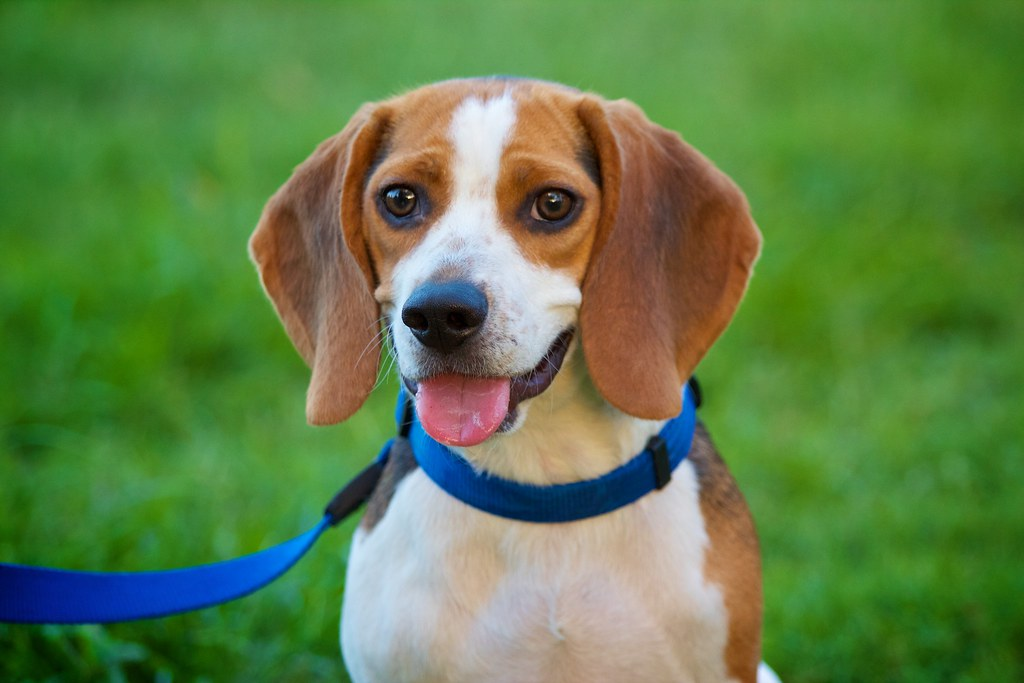

In [2]:
# Step 2.1: Read a PIL image and convert to RGB format.
img_path = os.path.join(os.getcwd(), "..", "assets", "dog.jpeg")
image = Image.open(img_path).convert("RGB")

# convert an image to numpy (for visualization purposes).
image_np = np.asarray(Image.open(img_path).convert("RGB"))

image_width = image.width
image_height = image.height

image

In [3]:
## STEP 2.2: Preprocess an input image
# The model is fine-tuned on the detection task using 1024x1024 resolution. Therefore, we resize the input PIL image to 1024x1024 size.
# After that, we convert the resized PIL image into a tensor. The values in tensor range between 0 and 255.
# We covert it to float and normalize it between 0.0 and 1.0 by dividing the tensor by 255.

img_transforms = Compose([Resize(size=(1024, 1024)), PILToTensor()])

input_tensor = img_transforms(image)
input_tensor = input_tensor.to(torch.float).div(255.0)

# add dummy batch dimension
input_tensor = input_tensor[None, ...]
input_tensor.shape

torch.Size([1, 3, 1024, 1024])

## STEP 3: Generate detection output

In [4]:
with torch.no_grad():
    # Feed the input tensor to the model. The shape of the input tensor is [batch_size, 3, height, width]
    # The output of the model will be [batch_size, num_classes, height, width]
    prediction: DetectionPredTuple = model.predict(input_tensor)

# convert tensors to numpy
boxes = prediction.boxes.cpu().numpy()
labels = prediction.labels.cpu().numpy()
scores = prediction.scores.cpu().numpy()

masks = prediction.masks

if masks is not None and masks.shape[0] > 0:
    # Resize the masks and convert them to binary
    masks = F.interpolate(
        masks.unsqueeze(0),
        size=(image_height, image_width),
        mode="bilinear",
        align_corners=True,
    ).squeeze(0)
    # convert to binary masks
    masks = masks > 0.5
    masks = masks.cpu().numpy()

# clip bounding boxes
boxes[..., 0::2] = np.clip(a_min=0, a_max=image_width, a=boxes[..., 0::2] * image_width)
boxes[..., 1::2] = np.clip(
    a_min=0, a_max=image_height, a=boxes[..., 1::2] * image_height
)

# Install OpenCV for visualization

In [5]:
%pip install opencv-contrib-python==4.5.5.64

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


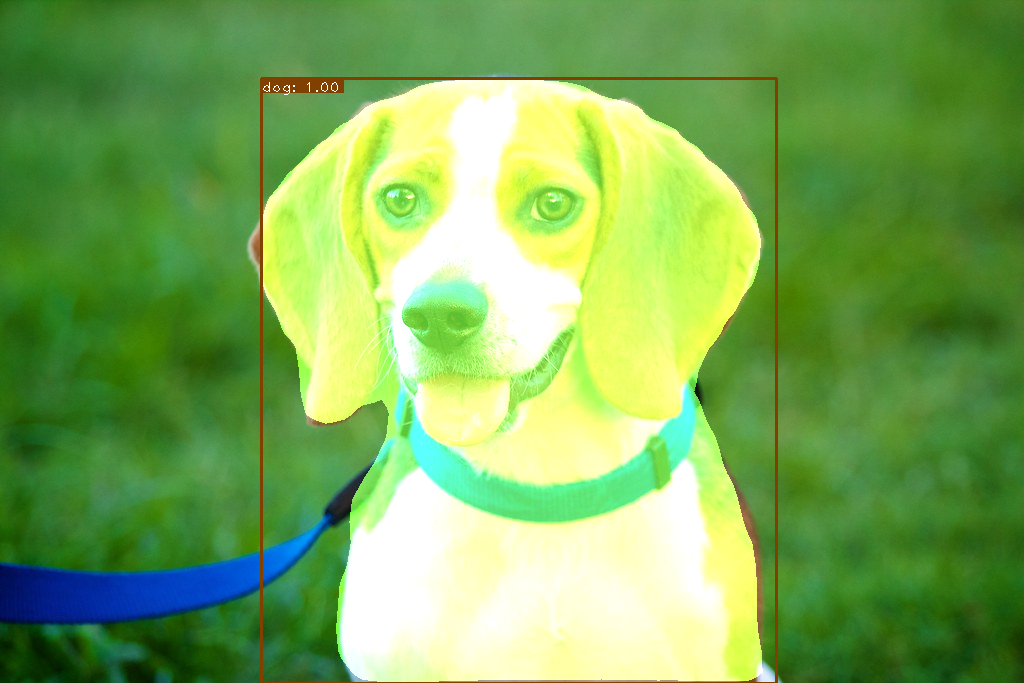

In [6]:
coco_class_names = [
    "background",
    "person",
    "bicycle",
    "car",
    "motorcycle",
    "airplane",
    "bus",
    "train",
    "truck",
    "boat",
    "traffic light",
    "fire hydrant",
    "stop sign",
    "parking meter",
    "bench",
    "bird",
    "cat",
    "dog",
    "horse",
    "sheep",
    "cow",
    "elephant",
    "bear",
    "zebra",
    "giraffe",
    "backpack",
    "umbrella",
    "handbag",
    "tie",
    "suitcase",
    "frisbee",
    "skis",
    "snowboard",
    "sports ball",
    "kite",
    "baseball bat",
    "baseball glove",
    "skateboard",
    "surfboard",
    "tennis racket",
    "bottle",
    "wine glass",
    "cup",
    "fork",
    "knife",
    "spoon",
    "bowl",
    "banana",
    "apple",
    "sandwich",
    "orange",
    "broccoli",
    "carrot",
    "hot dog",
    "pizza",
    "donut",
    "cake",
    "chair",
    "couch",
    "potted plant",
    "bed",
    "dining table",
    "toilet",
    "tv",
    "laptop",
    "mouse",
    "remote",
    "keyboard",
    "cell phone",
    "microwave",
    "oven",
    "toaster",
    "sink",
    "refrigerator",
    "book",
    "clock",
    "vase",
    "scissors",
    "teddy bear",
    "hair drier",
    "toothbrush",
]

# Filter predictions with low scores
keep = np.argwhere(scores > 0.5)[0]
valid_scores = scores[keep]
valid_boxes = boxes[keep]
valid_masks = masks[keep]
valid_labels = labels[keep]


overlayed_image = draw_bounding_boxes(
    image=image_np,
    boxes=valid_boxes,
    labels=valid_labels,
    scores=valid_scores,
    masks=valid_masks,
    object_names=coco_class_names,
    is_bgr_format=False,
)

overlayed_image_pil = Image.fromarray(overlayed_image)
overlayed_image_pil